In [134]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import csv

Plotting functions from Dimitri

In [2]:
# Where did this code come from?

# def radial_profile(data, center):
#     y, x = np.indices((data.shape))
#     r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
#     r = r.astype(np.int)

#     tbin = np.bincount(r.ravel(), data.ravel())
#     nr = np.bincount(r.ravel())
#     radialprofile = tbin / nr
#     return radialprofile

In [135]:
def radial_profile(data, center):
    """ Calculate the radial profile of a 2D array. """
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    # Define the desired thickness
    thickness = 4  # thickness in pixels
    
    # Bin the pixel values by their distances
    r_flat = r.ravel()
    image_flat = data.ravel()
    # Define bin edges with the desired thickness
    bin_edges = np.arange(0, r.max() + thickness, thickness)

    # Calculate the mean intensity within each bin
    radial_profile, bin_edges, binnumber = binned_statistic(r_flat, image_flat, statistic='mean', bins=bin_edges)

    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return radial_profile, bin_centers

In [21]:
def process_fits_file(file_path):
    """ Process a single FITS file and return the radial profiles. """
    with fits.open(file_path) as hdul:  
        profiles = {}
        bin_centers = {}
        dp = {}
        for i in range(0, len(hdul)):
            dp [f'extension_{i}'] = hdul[i].header['DP']
            data = hdul[i].data
            center = (data.shape[1] // 2, data.shape[0] // 2)
            profiles[f'extension_{i}'], bin_centers[f'extension_{i}'] = radial_profile(data, center)
    return profiles, bin_centers, dp

In [23]:
test_path = "D:/mcao_pyttf/25p_za0/mag12/evlpsfcl_1_x0_y0.fits"
process_fits_file(test_path)

({'extension_0': array([4.78594773e-02, 2.91832941e-03, 1.45995920e-03, 7.66356789e-04,
         5.29199076e-04, 3.31480856e-04, 2.30484230e-04, 1.65103752e-04,
         1.37503994e-04, 1.08667241e-04, 9.07890747e-05, 7.48831153e-05,
         6.45913014e-05, 5.19474595e-05, 4.31125933e-05, 3.79037762e-05,
         3.28509378e-05, 2.89045044e-05, 2.56514714e-05, 2.40532186e-05,
         2.28219521e-05, 2.11795517e-05, 1.93100497e-05, 1.73731196e-05,
         1.50483386e-05, 1.33613246e-05, 1.19581476e-05, 1.08666004e-05,
         9.33865984e-06, 8.66958397e-06, 7.72839712e-06, 6.97546429e-06,
         6.30924606e-06, 5.67374544e-06, 5.14046170e-06, 4.73856701e-06,
         4.28897591e-06, 3.97740716e-06, 3.57185930e-06, 3.24604263e-06,
         3.02082737e-06, 2.74241322e-06, 2.58838380e-06, 2.33089950e-06,
         2.12662599e-06, 1.95202460e-06, 1.85252586e-06, 1.73263463e-06,
         1.60165421e-06, 1.45344120e-06, 1.34083944e-06, 1.23404985e-06,
         1.15557894e-06, 1.07734991e

In [26]:
print(process_fits_file(test_path)[2])

{'extension_0': 0.00360963, 'extension_1': 0.00429718, 'extension_2': 0.00567228, 'extension_3': 0.00756304}


In [29]:
def process_fits_scale(file_path):
    """ Process a single FITS file and return the scale and dimensions. """
    with fits.open(file_path) as hdul:  
        dimensions = {}
        dp = {}
        for i in range(0, len(hdul)):
            dp [f'extension_{i}'] = hdul[i].header['DP']
            data = hdul[i].data
            dimensions[f'extension_{i}'] = data.shape
    return dimensions, dp

In [189]:
def error_handled_fits(file_path):
    """ Process a single FITS file and return the radius and profiles."""
    try:
        # Check if the file is empty (size is 0)
        if os.path.getsize(file_path) == 0:
            raise ValueError(f"File {file_path} is empty.")
        else:
            # Attempt to open the file with fits.open() if it's not empty
            with fits.open(file_path) as hdul:  
                profiles = {}
                bin_centers = {}
                dp = {}
                radii = {}
                for i in range(0, len(hdul)):
                    dp [f'extension_{i}'] = hdul[i].header['DP']
                    data = hdul[i].data
                    center = (data.shape[1] // 2, data.shape[0] // 2)
                    profiles[f'extension_{i}'], bin_centers[f'extension_{i}'] = radial_profile(data, center)
                    radii[f'extension_{i}'] = bin_centers[f'extension_{i}'] * dp[f'extension_{i}'] # convert pixels to angular separation in arcsec
            return radii, profiles
        
    except ValueError as e:
        # Handle the case where the file is empty
        print(e)
    except Exception as e:
        # Handle other exceptions, such as file not found
        print(f"An error occurred: {e}")

In [ ]:
# Now do this through an entire directory
def error_handled_directory(directory):
    """ Process all FITS files in the given directory and subdirectories to give radii and profiles. """
    results = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('x0_y0.fits'):
                file_path = os.path.join(root, file)
                radii, profiles = error_handled_fits(file_path)
                rel_dir = os.path.relpath(root, directory)
                if rel_dir not in results:
                    results[rel_dir] = []
                radii = np.array
                results[rel_dir].append((file, radii, profiles))
    return results

In [194]:
test_dict_radii = error_handled_fits(test_path)[0]
print(test_dict_radii)
print(test_dict_radii.get('extension_0'))

{'extension_0': array([7.21926000e-03, 2.16577800e-02, 3.60963000e-02, 5.05348200e-02,
       6.49733400e-02, 7.94118600e-02, 9.38503800e-02, 1.08288900e-01,
       1.22727420e-01, 1.37165940e-01, 1.51604460e-01, 1.66042980e-01,
       1.80481500e-01, 1.94920020e-01, 2.09358540e-01, 2.23797060e-01,
       2.38235580e-01, 2.52674100e-01, 2.67112620e-01, 2.81551140e-01,
       2.95989660e-01, 3.10428180e-01, 3.24866700e-01, 3.39305220e-01,
       3.53743740e-01, 3.68182260e-01, 3.82620780e-01, 3.97059300e-01,
       4.11497820e-01, 4.25936340e-01, 4.40374860e-01, 4.54813380e-01,
       4.69251900e-01, 4.83690420e-01, 4.98128940e-01, 5.12567460e-01,
       5.27005980e-01, 5.41444500e-01, 5.55883020e-01, 5.70321540e-01,
       5.84760060e-01, 5.99198580e-01, 6.13637100e-01, 6.28075620e-01,
       6.42514140e-01, 6.56952660e-01, 6.71391180e-01, 6.85829700e-01,
       7.00268220e-01, 7.14706740e-01, 7.29145260e-01, 7.43583780e-01,
       7.58022300e-01, 7.72460820e-01, 7.86899340e-01, 8.0133

In [204]:
len(list(test_dict_radii.values()))

4

In [192]:
np.array(list(test_dict_radii.values()))

array([[7.21926000e-03, 2.16577800e-02, 3.60963000e-02, ...,
        9.76765878e+00, 9.78209730e+00, 9.79653582e+00],
       [8.59436000e-03, 2.57830800e-02, 4.29718000e-02, ...,
        1.16281691e+01, 1.16453578e+01, 1.16625465e+01],
       [1.13445600e-02, 3.40336800e-02, 5.67228000e-02, ...,
        1.53491897e+01, 1.53718788e+01, 1.53945679e+01],
       [1.51260800e-02, 4.53782400e-02, 7.56304000e-02, ...,
        2.04655862e+01, 2.04958384e+01, 2.05260906e+01]])

In [116]:
test_dict_profile = error_handled_fits(test_path)[0]
# print(test_dict_profile)
print(test_dict_profile.get('extension_0'))

[4.78594773e-02 2.91832941e-03 1.45995920e-03 7.66356789e-04
 5.29199076e-04 3.31480856e-04 2.30484230e-04 1.65103752e-04
 1.37503994e-04 1.08667241e-04 9.07890747e-05 7.48831153e-05
 6.45913014e-05 5.19474595e-05 4.31125933e-05 3.79037762e-05
 3.28509378e-05 2.89045044e-05 2.56514714e-05 2.40532186e-05
 2.28219521e-05 2.11795517e-05 1.93100497e-05 1.73731196e-05
 1.50483386e-05 1.33613246e-05 1.19581476e-05 1.08666004e-05
 9.33865984e-06 8.66958397e-06 7.72839712e-06 6.97546429e-06
 6.30924606e-06 5.67374544e-06 5.14046170e-06 4.73856701e-06
 4.28897591e-06 3.97740716e-06 3.57185930e-06 3.24604263e-06
 3.02082737e-06 2.74241322e-06 2.58838380e-06 2.33089950e-06
 2.12662599e-06 1.95202460e-06 1.85252586e-06 1.73263463e-06
 1.60165421e-06 1.45344120e-06 1.34083944e-06 1.23404985e-06
 1.15557894e-06 1.07734991e-06 1.01147899e-06 9.48995905e-07
 8.74857048e-07 8.22285194e-07 7.84191979e-07 7.30552453e-07
 6.94328813e-07 6.29121170e-07 5.97593996e-07 5.65853535e-07
 5.31959440e-07 5.025859

In [172]:
test_array = test_dict_profile.get('extension_0')
test_array = np.array([test_array])

In [173]:
print(test_array)

[[4.78594773e-02 2.91832941e-03 1.45995920e-03 7.66356789e-04
  5.29199076e-04 3.31480856e-04 2.30484230e-04 1.65103752e-04
  1.37503994e-04 1.08667241e-04 9.07890747e-05 7.48831153e-05
  6.45913014e-05 5.19474595e-05 4.31125933e-05 3.79037762e-05
  3.28509378e-05 2.89045044e-05 2.56514714e-05 2.40532186e-05
  2.28219521e-05 2.11795517e-05 1.93100497e-05 1.73731196e-05
  1.50483386e-05 1.33613246e-05 1.19581476e-05 1.08666004e-05
  9.33865984e-06 8.66958397e-06 7.72839712e-06 6.97546429e-06
  6.30924606e-06 5.67374544e-06 5.14046170e-06 4.73856701e-06
  4.28897591e-06 3.97740716e-06 3.57185930e-06 3.24604263e-06
  3.02082737e-06 2.74241322e-06 2.58838380e-06 2.33089950e-06
  2.12662599e-06 1.95202460e-06 1.85252586e-06 1.73263463e-06
  1.60165421e-06 1.45344120e-06 1.34083944e-06 1.23404985e-06
  1.15557894e-06 1.07734991e-06 1.01147899e-06 9.48995905e-07
  8.74857048e-07 8.22285194e-07 7.84191979e-07 7.30552453e-07
  6.94328813e-07 6.29121170e-07 5.97593996e-07 5.65853535e-07
  5.3195

In [183]:
transposed_array = test_array.T
print(transposed_array.shape)

(679, 1)


In [187]:
contrast_path = "C:/Users/Willi/Documents/GitHub/specsim/data/contrast/"
os.chdir(contrast_path)
# os.getcwd()
array = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
test_csv = "renamed_test_csv.csv"
full_path = os.path.join(contrast_path, test_csv)

with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(transposed_array)  # Use writerow for a single row

print(f"Array written to {full_path}")

Array written to C:/Users/Willi/Documents/GitHub/specsim/data/contrast/renamed_test_csv.csv


In [184]:
os.rename("test_csv.csv", "renamed_test_csv.csv")

In [120]:
test_dict_radii = error_handled_fits(test_path)[3]
# print(test_dict_radii
print(test_dict_radii.get('extension_0'))

[7.21926000e-03 2.16577800e-02 3.60963000e-02 5.05348200e-02
 6.49733400e-02 7.94118600e-02 9.38503800e-02 1.08288900e-01
 1.22727420e-01 1.37165940e-01 1.51604460e-01 1.66042980e-01
 1.80481500e-01 1.94920020e-01 2.09358540e-01 2.23797060e-01
 2.38235580e-01 2.52674100e-01 2.67112620e-01 2.81551140e-01
 2.95989660e-01 3.10428180e-01 3.24866700e-01 3.39305220e-01
 3.53743740e-01 3.68182260e-01 3.82620780e-01 3.97059300e-01
 4.11497820e-01 4.25936340e-01 4.40374860e-01 4.54813380e-01
 4.69251900e-01 4.83690420e-01 4.98128940e-01 5.12567460e-01
 5.27005980e-01 5.41444500e-01 5.55883020e-01 5.70321540e-01
 5.84760060e-01 5.99198580e-01 6.13637100e-01 6.28075620e-01
 6.42514140e-01 6.56952660e-01 6.71391180e-01 6.85829700e-01
 7.00268220e-01 7.14706740e-01 7.29145260e-01 7.43583780e-01
 7.58022300e-01 7.72460820e-01 7.86899340e-01 8.01337860e-01
 8.15776380e-01 8.30214900e-01 8.44653420e-01 8.59091940e-01
 8.73530460e-01 8.87968980e-01 9.02407500e-01 9.16846020e-01
 9.31284540e-01 9.457230

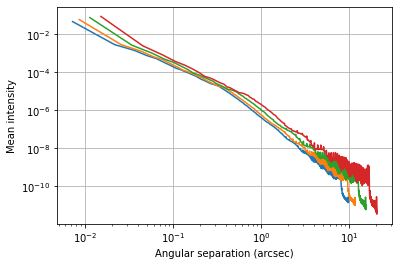

In [131]:
plt.xlabel('Angular separation (arcsec)')
plt.ylabel('Mean intensity')
plt.loglog(test_dict_radii.get('extension_0'), test_dict_profile.get('extension_0'))
plt.loglog(test_dict_radii.get('extension_1'), test_dict_profile.get('extension_1'))
plt.loglog(test_dict_radii.get('extension_2'), test_dict_profile.get('extension_2'))
plt.loglog(test_dict_radii.get('extension_3'), test_dict_profile.get('extension_3'))

plt.grid()
plt.show()

In [ ]:
# Now practice writing this information to a csv file


In [30]:
process_fits_scale(test_path)

({'extension_0': (3840, 3840),
  'extension_1': (3840, 3840),
  'extension_2': (3840, 3840),
  'extension_3': (3840, 3840)},
 {'extension_0': 0.00360963,
  'extension_1': 0.00429718,
  'extension_2': 0.00567228,
  'extension_3': 0.00756304})

In [31]:
def process_directory_scale(directory):
    """ Process all FITS files in the given directory and subdirectories to find scale and dimensions. """
    results = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.fits'):
                file_path = os.path.join(root, file)
                dimensions, dp = process_fits_scale(file_path)
                rel_dir = os.path.relpath(root, directory)
                if rel_dir not in results:
                    results[rel_dir] = []
                results[rel_dir].append((dimensions, dp))
    return results

In [58]:
test_directory = "D:/mcao_pyttf/50p_za45"
# test_directory = "D:/ngsao/ngsao"
process_directory_scale(test_directory)

{'mag12': [({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'extension_2': 0.00567228,
    'extension_3': 0.00756304}),
  ({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'extension_2': 0.00567228,
    'extension_3': 0.00756304})],
 'mag13': [({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'extension_2': 0.00567228,
    'extension_3': 0.00756304}),
  ({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'exte

In [5]:
def process_directory(directory):
    """ Process all FITS files in the given directory and subdirectories. """
    results = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.fits'):
                file_path = os.path.join(root, file)
                profiles, bin_centers, dp = process_fits_file(file_path)
                rel_dir = os.path.relpath(root, directory)
                if rel_dir not in results:
                    results[rel_dir] = []
                results[rel_dir].append((file, profiles, bin_centers, dp))
    return results

In [59]:
test_directory = "D:/mcao_pyttf/25p_za0/mag12"
test_results = process_directory(test_directory) # gives the file name and three dictionaries, each with 4 extension keys

In [78]:
print(test_results.items())

dict_items([('.', [('evlpsfcl_1_x0_y0.fits', {'extension_0': array([4.78594773e-02, 2.91832941e-03, 1.45995920e-03, 7.66356789e-04,
       5.29199076e-04, 3.31480856e-04, 2.30484230e-04, 1.65103752e-04,
       1.37503994e-04, 1.08667241e-04, 9.07890747e-05, 7.48831153e-05,
       6.45913014e-05, 5.19474595e-05, 4.31125933e-05, 3.79037762e-05,
       3.28509378e-05, 2.89045044e-05, 2.56514714e-05, 2.40532186e-05,
       2.28219521e-05, 2.11795517e-05, 1.93100497e-05, 1.73731196e-05,
       1.50483386e-05, 1.33613246e-05, 1.19581476e-05, 1.08666004e-05,
       9.33865984e-06, 8.66958397e-06, 7.72839712e-06, 6.97546429e-06,
       6.30924606e-06, 5.67374544e-06, 5.14046170e-06, 4.73856701e-06,
       4.28897591e-06, 3.97740716e-06, 3.57185930e-06, 3.24604263e-06,
       3.02082737e-06, 2.74241322e-06, 2.58838380e-06, 2.33089950e-06,
       2.12662599e-06, 1.95202460e-06, 1.85252586e-06, 1.73263463e-06,
       1.60165421e-06, 1.45344120e-06, 1.34083944e-06, 1.23404985e-06,
       1.1555789

In [113]:
# try an empty file
bad_file = "D:/mcao_pyttf/75p_za60/mag22/evlpsfcl_1_x0_y0.fits"

In [6]:
label_mapping = {
    'extension_0': 'y',
    'extension_1': 'J',
    'extension_2': 'H',
    'extension_3': 'K',
}

In [18]:
def plot_radial_profiles(results):
    """ Plot the radial profiles from the results dictionary. """
    for rel_dir, files_data in results.items():
        for file, profiles, bin_centers, dp in files_data:
            plt.figure(figsize=(10, 6))
            for ext, profile in profiles.items():
                radii = bin_centers[ext] * dp[ext]  # Convert pixel radius to arcseconds
                label = label_mapping.get(ext, ext)  # Default to ext if no mapping is found
                plt.loglog(radii, profile, label=label)
            plt.xlabel('Radius (arcseconds)', fontweight='bold')
            plt.ylabel('Intensity', fontweight='bold')
            plt.title(f'Radial Profile for {file}', fontweight='bold')
            plt.legend()
            plt.grid(True)
            plt.show()

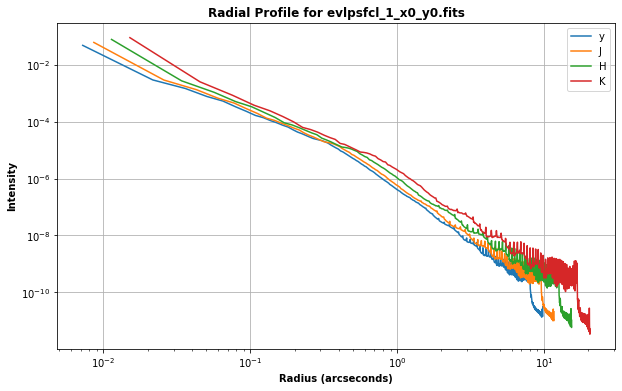

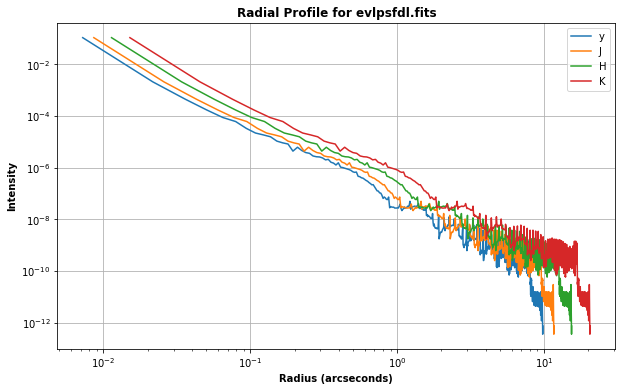

In [19]:
plot_radial_profiles(test_results)

In [8]:
test_directory2 = "D:/mcao_pyttf/25p_za0"
test_results2 = process_directory(test_directory2)

In [13]:
print(test_results2)

{'mag12': [('evlpsfcl_1_x0_y0.fits', {'extension_0': array([4.78594773e-02, 2.91832941e-03, 1.45995920e-03, 7.66356789e-04,
       5.29199076e-04, 3.31480856e-04, 2.30484230e-04, 1.65103752e-04,
       1.37503994e-04, 1.08667241e-04, 9.07890747e-05, 7.48831153e-05,
       6.45913014e-05, 5.19474595e-05, 4.31125933e-05, 3.79037762e-05,
       3.28509378e-05, 2.89045044e-05, 2.56514714e-05, 2.40532186e-05,
       2.28219521e-05, 2.11795517e-05, 1.93100497e-05, 1.73731196e-05,
       1.50483386e-05, 1.33613246e-05, 1.19581476e-05, 1.08666004e-05,
       9.33865984e-06, 8.66958397e-06, 7.72839712e-06, 6.97546429e-06,
       6.30924606e-06, 5.67374544e-06, 5.14046170e-06, 4.73856701e-06,
       4.28897591e-06, 3.97740716e-06, 3.57185930e-06, 3.24604263e-06,
       3.02082737e-06, 2.74241322e-06, 2.58838380e-06, 2.33089950e-06,
       2.12662599e-06, 1.95202460e-06, 1.85252586e-06, 1.73263463e-06,
       1.60165421e-06, 1.45344120e-06, 1.34083944e-06, 1.23404985e-06,
       1.15557894e-06, 1

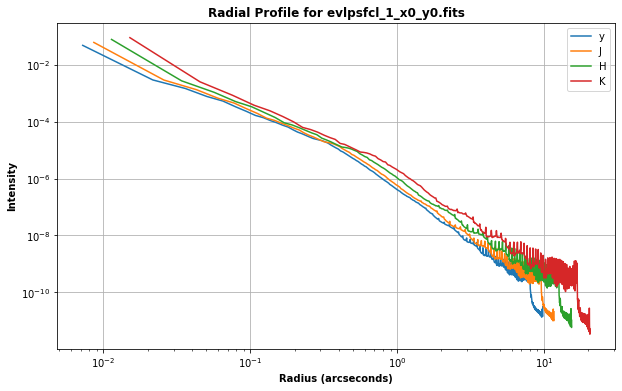

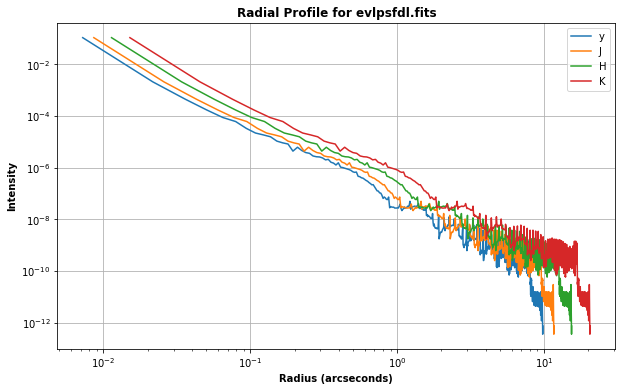

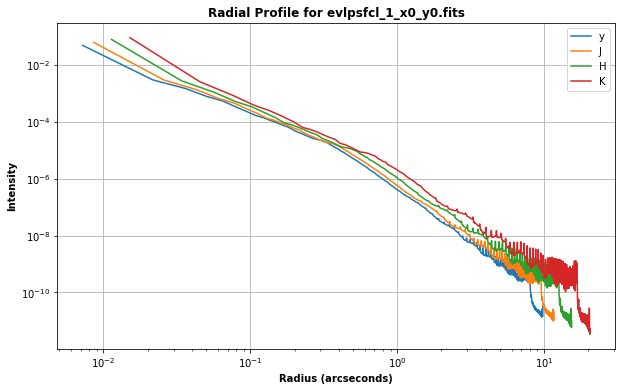

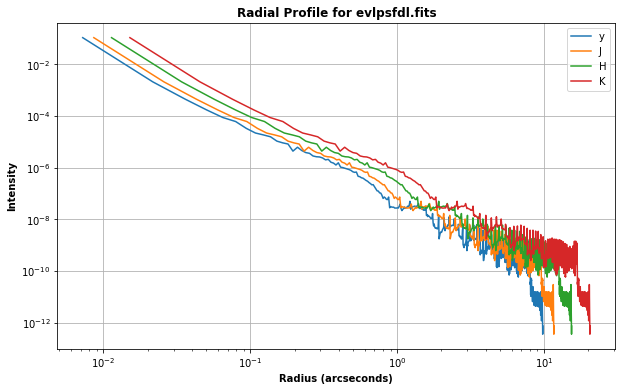

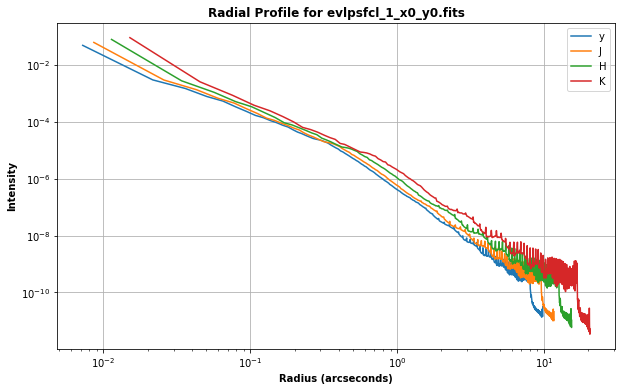

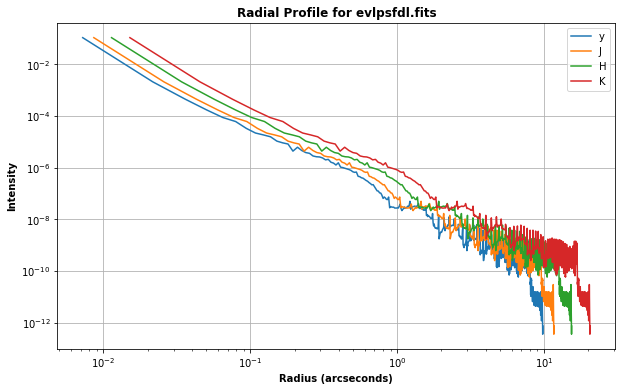

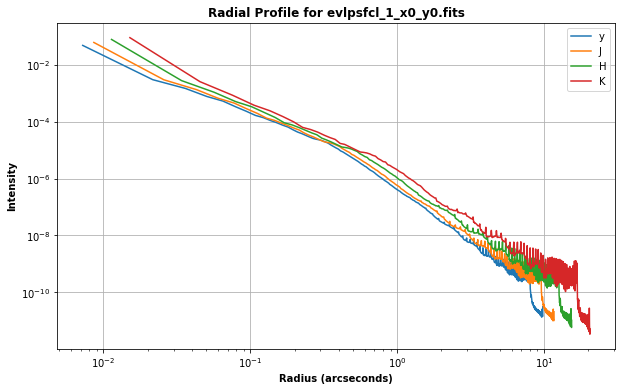

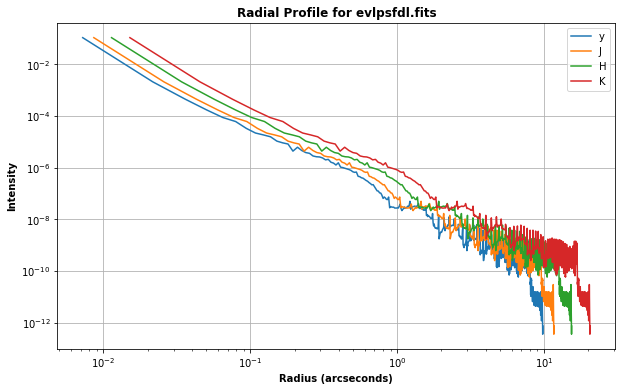

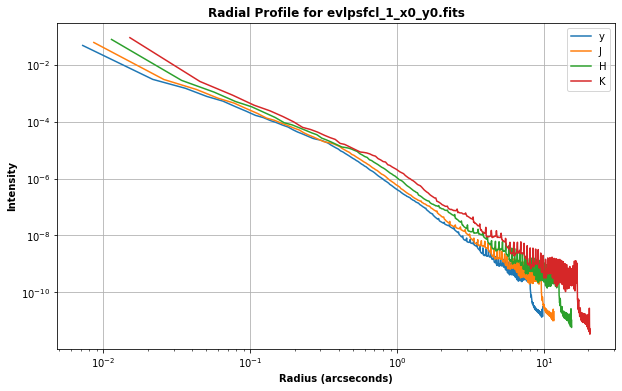

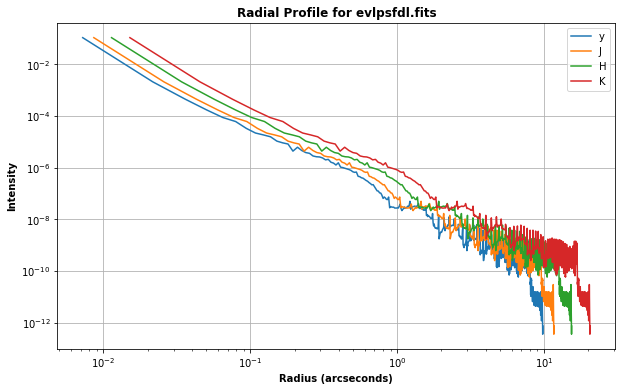

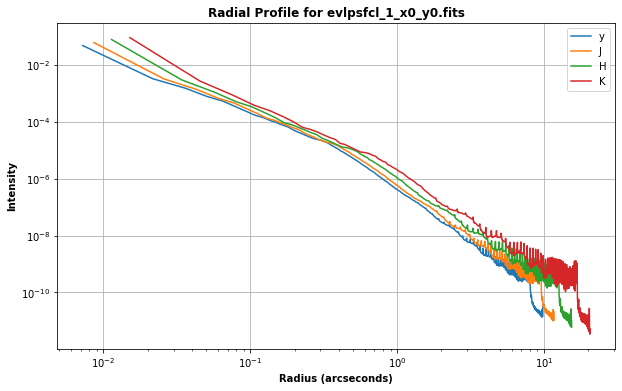

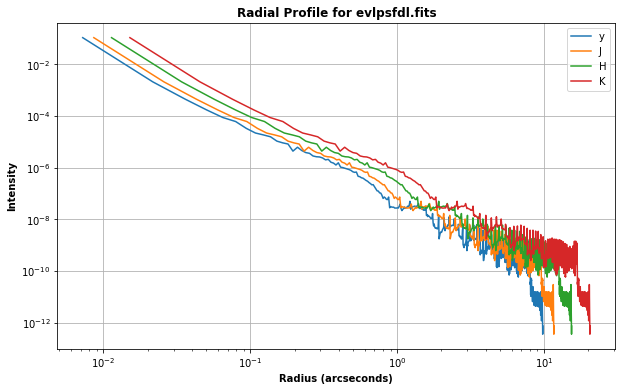

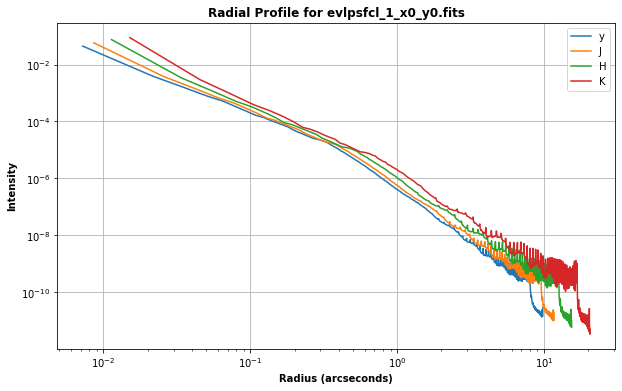

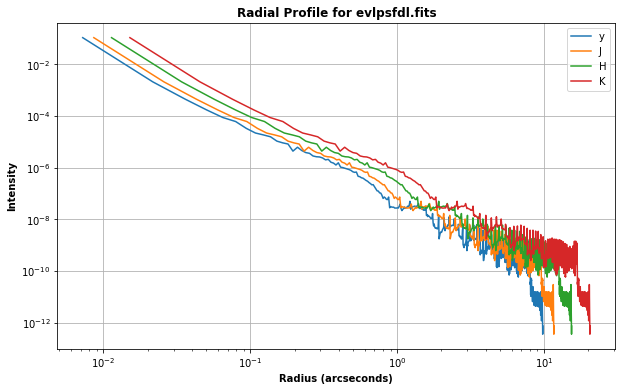

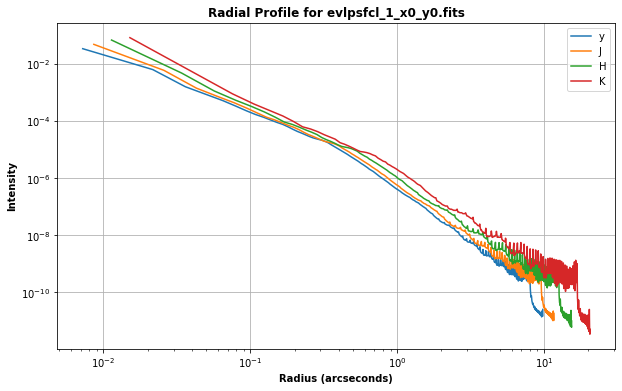

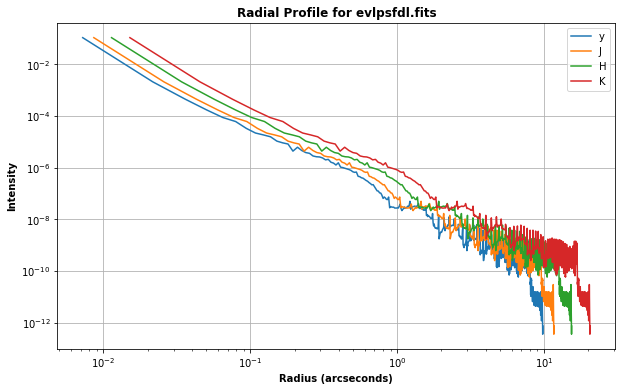

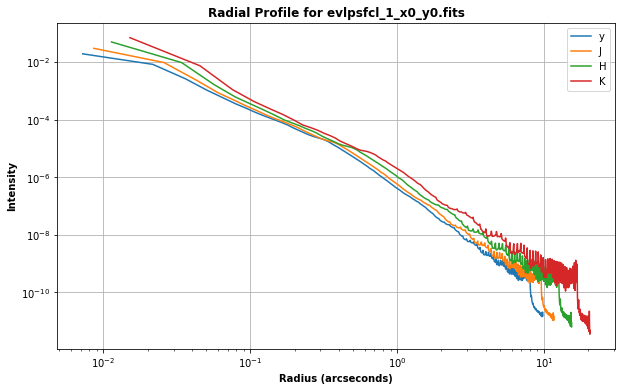

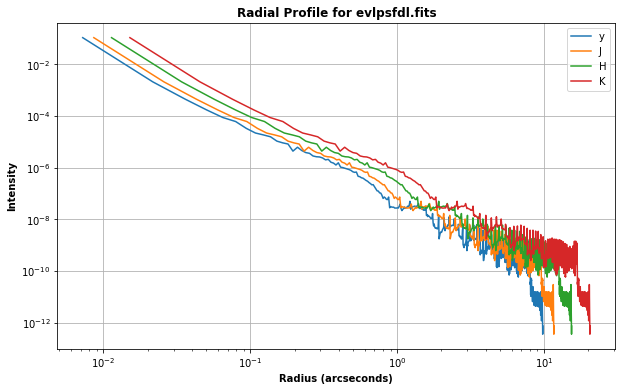

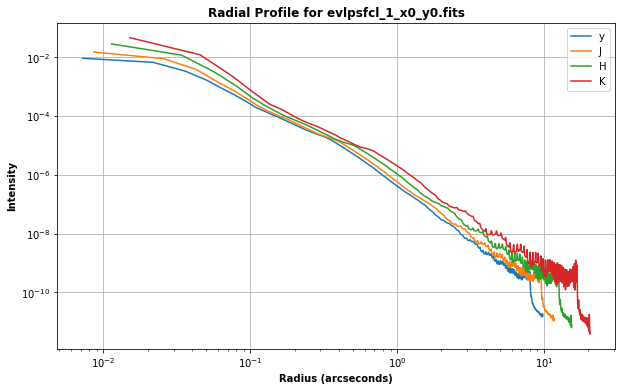

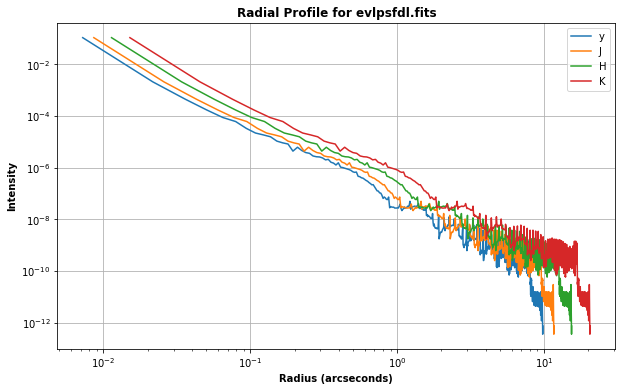

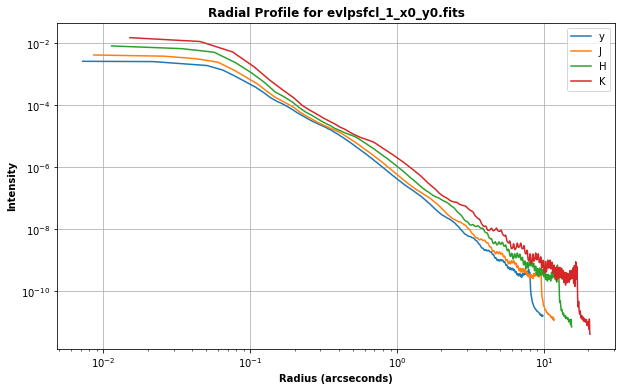

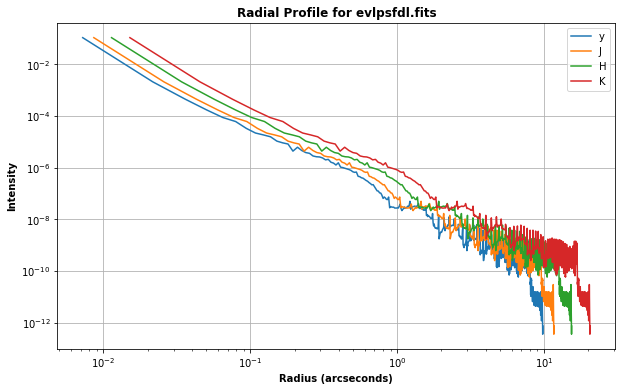

In [9]:
plot_radial_profiles(test_results2)

In [ ]:
# Example usage
current_directory = os.getcwd()
base_directory = current_directory
results = process_directory(base_directory)
plot_radial_profiles(results)